# Molecular Mechanics

Quantum mechanics accurately describes the properties of atoms and molecules. Solving the Schrodinger's equation for molecular systems is the goal of *ab initio* wavefunction methods and density functional theory. Unfortunately, these methods are very computationally expensive, and therefore they are limited to small systems. Semiempirical methods have lower computational scaling but they are still not routinely applicable for large molecular systems (e.g. proteins). Furthermore, given their steep computational cost, quantum chemical models are usually restricted to calculating the properties of molecules in their minimum energy structures or using a handful of possible conformations.

**Molecular mechanics** or **force field** methods sidestep the quantum mechanical nature of molecules altogether. Molecules are represented by atoms and bonds while electrons are no longer explicitly considered. The interactions between atoms are described classically using empirical formula that have a multitude of parameters. This is an enormous simplificantion that makes these methods applicable for very large systems.

A major assumption in force field methods is that force field parameters are *transferable*. That is, they can be used across a broad range of molecular systems. For example, the C-H bond length is usually the same for all molecules in their equilibrium geometries, being between 1.06 and 1.10 Angstrom. The C-H stretching frequency is usually between 2900 and 3300 cm$^{-1}$ and therefore the C-H force constants are comparable across various systems.

## Atom Types
Force fields usually rely on the concept of **atom types**. An atom type is a label that denotes an atom with a given chemical environment. For example, a carbon atom that is sp$^3$ hybridized have a distinct chemical environment from a carbon atom in a carbonyl group (C=O). Thus, they can be assigned different atom types. Force fields differ in their definitions and assignment of atom types. The following table shows an example list of atomic types from the MM2(91) force field:
<img src="atom_types.png" alt="drawing" width="600px"/>

*All-atom* force fields assign atom types to all the atoms present in the system. Because hydrogen atoms are often the most numerous, significant reduction in the compuational cost can be achieved by not explicitly accounting for the hydrogen atoms. *United atom* force fields model atoms with attached hydrogens as a single particle.

To model very large systems, even all-atom or united-atom force fields can be expensive. *Coarse grained* models group several atoms together into a single particle, called *bead*. A typical coarse grained force field combine four heavy atoms along with their hydrogens to form a single bead. Then, the energy is calculated using similar functional forms to all-atom force fields.

## The Force Field Energy
The force field energy is usually written as a sum of energy terms:
\begin{align}
    E_{\rm FF} = E_{\rm str} + E_{\rm bend} + E_{\rm tors} + E_{\rm vdw} + E_{\rm el} + E_{\rm cross}
\end{align}
where $E_{\rm str}$ is the energy required for *stretching* a bond, $E_{\rm bend}$ is the energy required for *bending* an angle, $E_{\rm tors}$ is the energy of *torsional* rotation, $E_{\rm vdw}$ is the *van der Waals* energy, $E_{\rm el}$ is the *electrostatic* energy, and $E_{\rm cross}$ is a *crossing* term that describes the coupling between the various bonded terms (the first three terms). A visual representation of the various terms is shown below:

<img src="force_field_terms_illustration.png" alt="drawing" width="300px"/>

### The Stretch Energy

Consider the following potential energy surface of the diatomic molecule F$_2$:

<IPython.core.display.Javascript object>


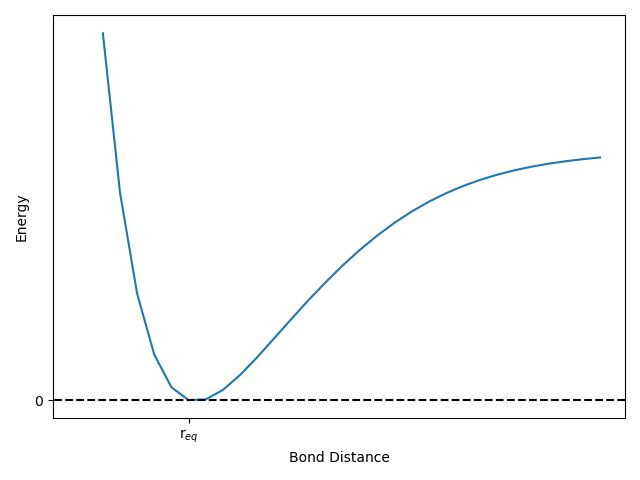

In [1]:
%matplotlib notebook
import psi4
import numpy as np
import matplotlib.pyplot as plt

psi4.set_output_file("output.dat", True)
mol = psi4.geometry("""
F
F 1 x""")

distances = np.linspace(1, 3, 30)
energies = []
for d in distances:
    mol.x = d
    energies.append(psi4.energy("b3lyp/sto-3g"))

energies = np.array(energies)
energies -= np.min(energies)
minimum_r = distances[np.argmin(energies)]

plt.figure()
plt.plot(distances, energies)
plt.hlines([0], 0.5, 3.5, color='black', ls='--')
plt.xlim(0.8, 3.1)
plt.xticks([minimum_r], ["r$_{eq}$"])
plt.yticks([0], ["0"])
plt.xlabel("Bond Distance")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()

We can arbitrarily set the minimum potential energy to zero. At the equilibrium or minimum energy bond length, we can expnd the potential energy using a Taylor series:
\begin{align}
    E(r) = E(r_{\rm eq}) + \left. \frac{dE}{dr} \right |_{r=r_{\rm eq}} (r-r_{\rm eq}) + 
          \left. \frac{1}{2!}\frac{d^2 E}{dr^2} \right |_{r=r_{\rm eq}} (r-r_{\rm eq})^2 +
          \left. \frac{1}{3!}\frac{d^3 E}{dr^3} \right |_{r=r_{\rm eq}} (r-r_{\rm eq})^3 + \cdots
\end{align}
The first term is set to zero arbitrarily, and the second term is zero because the first derivative is zero at the minimum. Thus, using the first nonzero term, we arrive at the Hooke's law expression:
\begin{align}
    E(r) = \frac{1}{2} k (r-r_{\rm eq})^2
\end{align}
where the force constant $k=\left. \frac{d^2 E}{dr^2} \right |_{r=r_{\rm eq}}$. This form is called a harmonic potential (depends on the square of the displacement). Farther away from the equilibrium bond length, the harmonic approximation becomes no longer appropriate. Additional terms in the Taylor expansion can be added. However, many force fields truncate the expansion to the harmonic potential. Note that trunctated Taylor expansions will not have the correct limiting behavior at long distances. While the Morse potential has the correct behavior:
\begin{align}
    E_{\rm Morse}(r) = D \left [1-e^{-\alpha (r-r_{\rm eq})}\right ]^2.
\end{align}
However, the Morse potential is not computationally efficient. It provides a small restoring force when the bond is stretched and therefore it can be slow during optimization. Most force fields study systems where the various degrees of freedom are close to the equilibrium value, and therefore the Taylor expansion is usually used. Note that some force fields absorb the factor $\frac{1}{2}$ in the force constant for the harmonic potential.

What is the meaning of the equilibrium bond length $r_{\rm eq}$ in this context? For a diatomic molecule, the equilibrium bond length is distance at which the potential energy is a minimum. However, for polyatomic molecules, other atoms will influence the bond length of a given pair of atoms, and therefore the minimum energy structure is unlikely to have the specified equilibrium bond length. However, most molecules will display limited deviation from the assigned equilibrium bond length.

Having specified the functional form for the stretching energy, what is needed is to determine the value of the force constant $k^{\rm AB}$ and the equilibirum bond length $r_{\rm eq}^{\rm AB}$ for all pairs of atom types.

## The Bending Energy
The energy associated with bending the angle $\theta$ between three bonded atoms can similarly be expressed using a harmonic potential:
\begin{align}
    E(\theta) = \frac{1}{2} k (\theta - \theta_{\rm eq})^2
\end{align}
where again $k$ is the force constant and $\theta_{\rm eq}$ is the equilibrium angle. The bending energy can similarly include higher order terms in the series expansion. Note that the harmonic potential fails to describe the barrier to linearity. For example, water molecule has an energy maximum in the linear form and therefore the energy derivative is equal to zero and the second derivative is negative. This cannot be enforced for harmonic potentials. Another potential issue is that certain angles may have multiple minima, especially in metallic systems. For example, for the triagonal bipyramidal PCl$_3$, there are three stable Cl-P-Cl bending angles corresponding to axial/equatorial, equatorial/equatorial, and axial/axial combinations.

Again, we need to determine the value of the force constant $k^{\rm ABC}$ and the equilibirum angle $\theta_{\rm eq}^{\rm ABC}$ for all triples of atom types

## The Torsional Energy
The torsional angle between four consecutive atoms A, B, C, and D is the angle between the ABC plane and the BCD plane. The torsional angle is periodic and it is usually defined between 0 and 360$^\circ$ or between -180 and 180$^\circ$.

Because the torsional angle is periodic, the potential energy as a function of the torsional angle is also periodic.  Moreover, torsional energy barriers are often small and therefore large deviations from the minimum energy torsional angle are often possible. Therefore, a Taylor expansion of the form used for the stretching and bending energies is not suitable. Instead, the torsional energy is usually expanded in terms of a periodic Fourier series:
\begin{align}
    E_{\rm tors}(\omega) = \sum_{n=1} V_n {\rm cos}(n \omega).
\end{align}
The $n$ factor controls the periodicity of the torsional angle. For example, $n=1, 2, 3$ corresponds to periodicities of 360, 180, 120$^\circ$. The $V_n$ determines the energy barrier to the rotation. A negative $V_n$ value converts a minimum to a maximum.

To illustrate the potential energy shape, we plot below the energy function for $n=1, 2, 3$ and set $V_n=1$. 

<IPython.core.display.Javascript object>


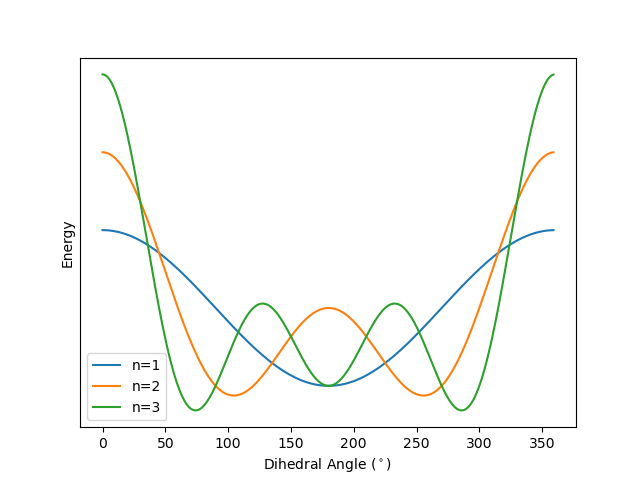

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def torsional_energy(omega, Vn):
    omega = np.array(omega) * np.pi / 180.0
    energy = np.zeros(omega.size) 
    for n in range(1, len(Vn) + 1):
        energy += Vn[n-1] * np.cos(n * omega)
        
    return energy

angles = np.arange(0, 360, 1)
Vn = []

plt.figure()

for n in range(1, 4):
    Vn.append(1)
    energy = torsional_energy(angles, Vn)

    plt.plot(angles, energy, label="n=%i" %n)

plt.legend()
plt.xlabel("Dihedral Angle ($^\circ$)")
plt.ylabel("Energy")
plt.yticks([], [])
plt.show()

Force fields sometimes use a slightly different expression given by
\begin{align}
    E (\omega) = \frac{1}{2} \sum_n V_n [1 + (-1)^{n+1} {\rm cos}(n \omega + \psi_n)]
\end{align}
where $\psi_n$ is a phase factor. The $\frac{1}{2}$ is included so that the $V_n$ term is equal to the maximum value that a particular term can contribute to the energy. The sign factor $(-1)^{n+1}$ is included so that the value in bracket to is zero at $\omega=180^\circ$ if $\psi=0$.

The symmetry of the molecule determines which values of $n$ are allowed in the expansion (or which $V_n$ terms are zero). For example, for ethane, there are three equivalent staggered configurations that are energy minima while there are three equivalent eclipsed configuration that are energy mixima. Therefore, only terms with $n=3, 6, 9, \cdots$ are allowed.

Torsional energy profiles 

<IPython.core.display.Javascript object>


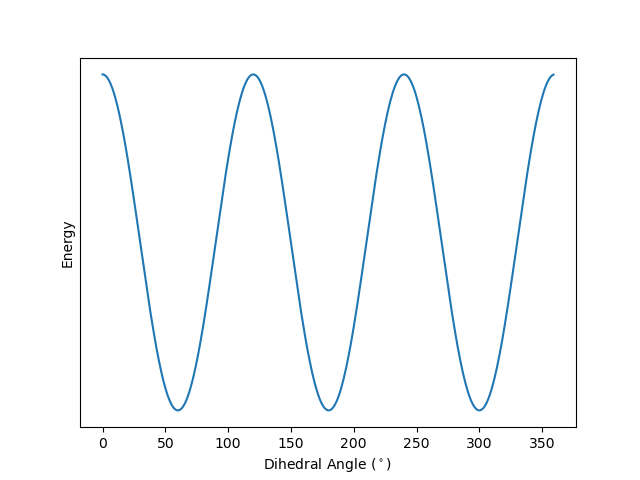

In [3]:
from openbabel import openbabel as ob
import numpy as np
import matplotlib.pyplot as plt

conv = ob.OBConversion()
mol = ob.OBMol()
conv.SetInFormat("xyz")
xyz_string = """8

C    0.00000000  0.00000000  0.00000000
C    1.53832585  0.07178854 -0.00000000
H    1.94916961 -0.93781901  0.00000000
H    1.87731148  0.60199800 -0.88998127
H    1.87731148  0.60199800  0.88998127
H   -0.41084377  1.00960755 -0.00000000
H   -0.33898564 -0.53020946 -0.88998127
H   -0.33898564 -0.53020946  0.88998127"""
conv.ReadString(mol, xyz_string)

ff = ob.OBForceField_FindForceField("MMFF94")

angles = np.arange(0, 360, 1)
energies = []
for a in angles:
    mol.SetTorsion(3, 2, 1, 6, a*np.pi/180.0)
    ff.Setup(mol)
    energies.append(ff.Energy())

plt.figure()
plt.plot(angles, energies)
plt.yticks([], [])
plt.xlabel("Dihedral Angle ($^\circ$)")
plt.ylabel("Energy")
plt.show()

## Out-of-Plane Bending and Improper Torsions
A special force field term is often needed to describe the energy associated with making the geometry of four atoms pyramidal. The figure below illustrates the pyramidal structure:
<img src="out_of_plane_bending.png" alt="drawing" width="400px"/>

For a planar structure, $\angle_{\rm ABC} + \angle_{\rm ABD} + \angle_{\rm CBD} = 360^\circ$. Large pyramidalization can be achieved while the sum of the three angles remain close to 360$^\circ$. For example, if the bond distances are 1.5 Angstroms, moving the central atom by 0.2 Angstroms out of the plane ($\chi=7.7^\circ$) reduces the sum only to 354.8$^\circ$. Very large angle bending force constants would be needed if the ABC, ABD, and CBD bending potentials are used to describe pyramidalization energy. This would make the in-plane bending potential too stiff. Therefore, a special out-of-plane bending term is often added while the in-plane angle-bending is treated as described above. The out-of-plane bending potential is modeled as
\begin{align}
    E_{\rm oop}(\chi) = k \chi^2 \quad {\rm or} \quad E_{\rm oop}(d) = k d^2.
\end{align}

Instead of using the above out-of-plane bending potential, sometimes an *improper* torsional potential is defined in terms of the torsional angle ABCD (some of the atoms are nonbonded). The torsional energy can have a harmonic form ($(\omega - \omega_{\rm eq})^2$ or can be described by the above Fourier expansion with large $V_2$ constant. 

## The van der Waals Energy
van der Waals and electrostatic energy terms describe the interactions between nonbonded atoms. The van der Waals interaction consists of two terms: one slightly attractive at long distances, and one strongly repulsive at short distances. The attractive force is due to disperion interaction, which are typically thought of as induced dipole-induced dipole interactions. This attractive force is what binds noble gas atoms at low temperatures. The leading term in the dispersion forces can theoretically be shown to have an $r^{-6}$ dependence. On the other hand, the repulsive force between two atoms arise because of the repulsion between electronic clouds as the atoms approach each other.

van der Waals interactions are usually modeled using the **Lennard-Jones potential**:
\begin{align}
    E_{\rm LJ}(r) = 4 \epsilon \left[ \left (\frac{\sigma}{r} \right )^{12} - \left (\frac{\sigma}{r} \right )^{6} \right ]
\end{align}
where $\epsilon$ is the Lennard-Jones well-depth and $\sigma$ is the interatomic separation where the repulsive and attractive forces are equal.

Why is the $r^{-12}$ dependence chosen for the repulsive part? In fact, there is no theoretical justification but it used because it is computationally efficent. The $r^{-12}$ value can be obtained by multiplying the physically justified $r^{-6}$ term by itself. Furthermore, computing the distance between two atoms require taking the square root
\begin{align}
    r_{\rm AB} = \sqrt{(x_{\rm A} - x_{\rm B})^2 + (y_{\rm A} - y_{\rm B})^2 + (z_{\rm A} - z_{\rm B})^2}
\end{align}
Having *even* powers in the energy function allows one to avoid computing the square root. Additionally, more physically justifiable functional forms, such as the Morse potential, requires computing an exponential, which roughly takes five times the CPU time needed for simpler mathematical functions, such as addition and multiplication. Is this in fact needed? It turns out that computing the nonbonded terms is the most computationally expensive steps in force field calculations. This is because there are ${\sim N^2}$ number of possible atomic pairs in a system.

Most classical force fields use the Lennard-Jones potential for modeling van der Waals interaction. However, some advanced force field or for some special systems, other functional forms are used. The repulsive part of the Lennard-Jones potential is too strong. This is rarely a problem because in typical molecular simulations, the available thermal energy is not sufficient to sample the high energy region of the potential energy surface.

How are the $\sigma$ and $\epsilon$ parameters determined? These parameters depend on the atom types for the atom pairs A and B. Typically, $\sigma$ and $\epsilon$ values are assigned for each atom type, and the $\sigma$ and $\epsilon$ values for the atom pair is determined using a specific *combination rule*. This is usually the arithmetic mean for $\sigma$ and the geometric mean for $\epsilon$:
\begin{align}
    \sigma^{\rm AB} &= \frac{1}{2} ( \sigma_{\rm A} + \sigma_{\rm B}) \\
    \epsilon^{\rm AB} &= \sqrt{ \epsilon_{\rm A} \epsilon_{\rm B}}
\end{align}
However, other combination rules are also often used.

It should be noted that van der Waals interaction, and also electrostatic interactions discussed below, are usually set to zero for pairs of atoms involved in bonds or angles because the bonded terms account for their interaction. The nonbonded terms for atom pairs that share a dihedral angle (1-4 atoms) are scaled down by a fixed factor in some force fields.

Below we illustrate the dependence of the Lennard-Jones potential on $\epsilon$ and $\sigma$.

<IPython.core.display.Javascript object>


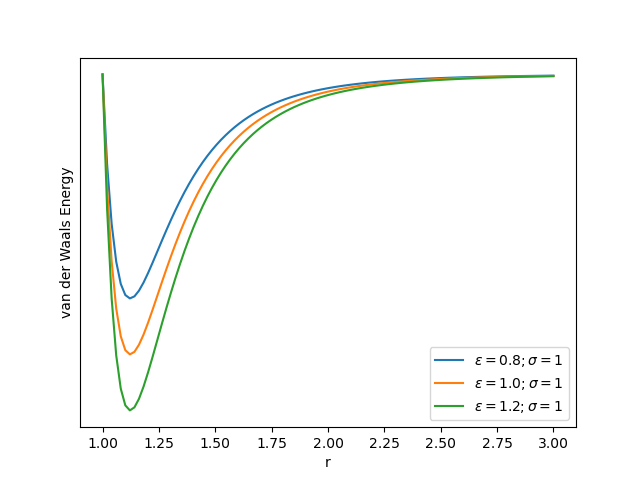

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def lennard_jones(r, epsilon, sigma):
    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(1, 3, 100)
sigma = 1
plt.figure()
for epsilon in [0.8, 1, 1.2]:
    plt.plot(distances, lennard_jones(distances, epsilon, sigma),
             label="$\epsilon=%.1f; \sigma=%.0f$" %(epsilon, sigma))

plt.xlabel("r")
plt.ylabel("van der Waals Energy")
plt.yticks([], [])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


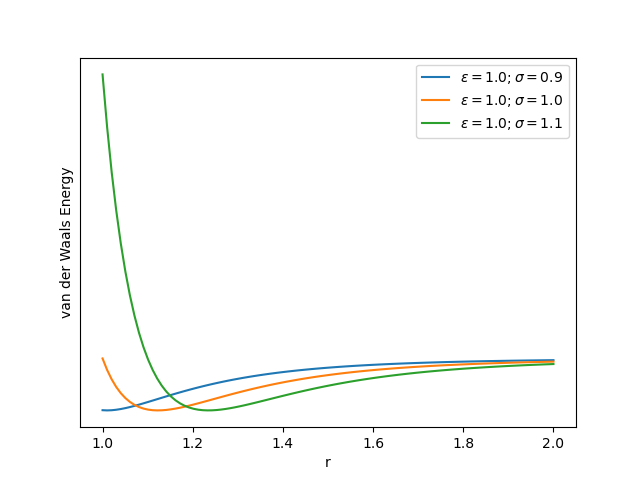

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def lennard_jones(r, epsilon, sigma):
    return 4*epsilon * ((sigma/r)**12 - (sigma/r)**6)

distances = np.linspace(1, 2, 100)
epsilon = 1
plt.figure()
for sigma in [0.9, 1, 1.1]:
    plt.plot(distances, lennard_jones(distances, epsilon, sigma),
             label="$\epsilon=%.1f; \sigma=%.1f$" %(epsilon, sigma))

plt.xlabel("r")
plt.ylabel("van der Waals Energy")
plt.yticks([], [])
plt.legend()
plt.show()

## The Electrostatic Energy
The classical electrostatic energy between two atoms is usually modeled as the Coulomb's law interaction between atom-centered point charges:
\begin{align}
    E_{\rm el}(r_{\rm AB}) = \frac{q_{\rm A} q_{\rm B}}{\epsilon r_{\rm AB}}
\end{align}
where $q_{\rm A}$ and $q_{\rm B}$ are the partial charges of atoms A and B and $\epsilon$ is the dielectric constant. Note that the value of $\epsilon$ is actually a parameter of the model and is not necessarily 1 (for vacuum) or that of the solvent. For example, $\epsilon$ can be set to zero for 1-2 and 1-3 interactions, 3 for 1-4 interactions, and 1.5 for other interactions. Sometimes, the value of $\epsilon$ is made distance dependent (e.g. $\epsilon=\epsilon_0 r_{\rm AB}$) to model charge screening by solvent molecules. However, there is little theoretical justification for such a scheme. The various models for parameterizing the partial charges were discussed in a previous lecture.

An alternative model for calculating the electrostatic energy is to consider each bond as an electric dipole and calculate the interaction between the dipoles. Then, the electrostatic energy is given by:
\begin{align}
    E_{\rm el} (R^{\rm AB}) = \frac{\mu^A \mu^B}{\epsilon (R^{\rm AB})^3}({\rm cos} \chi - 3 {\rm cos} \alpha_{\rm A} {\rm cos} \alpha_{\rm B}). 
\end{align}
The geometric parameters shown in the following diagram:
<img src="dipole_dipole.png" alt="drawing" width="200px"/>

Most classical force fields use the above charge-charge interaction model. This neglects the contribution of higher order multipole moments to the electrostatic energy. Advanced force fields usually include higher order multipole moments, such as the dipole and quadrupole. The Distributed Multipole Analysis (DMA) is a common scheme for representing the electrostatic energy. The multipole expansion accurate only at a sufficiently far distance.

The force fields that depend on permenant and fixed charge or electric moment values are called *pair-wise*, *additive*, or *nonpolarizable*. These force fields neglect the polarization of one molecule by another (e.g. dipole-induced dipole interactions). Furthermore, these force fields typically use constant values for the charges that do not change as the geometry chages (although the charges themselves can be fitted to multiple conformations of the molecules).

The above limitations of pair-wise force fields are addressed by more advanced *polarizable* force fields. Various approaches have been developed to describe polarization, such as the ﬂuctuating charge and the Drude oscillator models. Polarizable force fields are generally slower than nonpolarizable force fields.

In the ﬂuctuating charge model, the atomic charges adapt to the changes in geometry. The energy can be expanded as a function of the number of electrons $N$:
\begin{align}
    E = E_0 + \frac{\partial E}{\partial N} \Delta N + \frac{1}{2} \frac{\partial^2 E}{\partial N^2} (\Delta N)^2 + \cdots
\end{align}
The first derivative is the negative of the electronegativity $\chi$ ($\frac{\partial E}{\partial N}=-\chi$), and the second derivative is the hardness $\eta$. For an atom in a molecule, the change in the number of electrons is the negative of the change in the atomic charges ($\Delta N = \Delta Q$). Expanding at a point with no atomic charge, we get:
\begin{align}
    E = \chi Q + \frac{1}{2} \eta Q^2 + \cdots
\end{align}

Adding a term for the interaction of the point charges with an external electrostatic potential $\phi$, terminating at second order, and summing over all atomic sites, the electrostatic energy becomes:
\begin{align}
    E_{\rm el} = \sum_A \phi_A Q^A + \sum_A \chi_A Q^A + \frac{1}{2} \sum_{AB} \eta_{AB} Q^A Q^B.
\end{align}
In vector-matrix notation and requiring the energy is stationary with and without an external potential:
\begin{align}
    \left . \frac{\partial E_{\rm el}}{\partial \textbf{Q}} \right |_{\phi \neq 0} &= \phi + \chi + {\pmb \eta } \textbf{Q} = 0 \\
    \left . \frac{\partial E_{\rm el}}{\partial \textbf{Q}} \right |_{\phi = 0} &= \chi + {\pmb \eta} \textbf{Q}^0 = 0
\end{align}
Subtracting the two equations,
\begin{align}
    \Delta \textbf{Q} = - {\pmb \eta}^{-1} \phi.
\end{align}
This equation perscribes how the atomic charges fluctuate. However, because the electostatic potential itself depends on the charges:
\begin{align}
    \phi(\textbf{r}) \sum_A \frac{Q^A}{|\textbf{r}-\textbf{R}_A|},
\end{align}
the equations need to be solved iteratively. Once solved, the electrostatic energy will just be the Coulomb interaction between the atomic charges.

In the Drude oscillator model, part of the atomic charge is transferred to a fictitious virtual site (Drude particle) that is connected to the atom by a harmonic spring. The polarizability $\alpha$ is related to the Drude particle charge $Q_{\rm D}$ and the force constant $k_{\rm D}$ by
\begin{align}
    \alpha = \frac{Q_{\rm D}^2}{k_{\rm D}}.
\end{align}
The force constant must be large so that the Drude particle stays close to the real atom. The Drude particle can be assigned as a mass taken from the particle or can be massless. 

The electrostatic energy is usually the dominant component of the energy for molecular systems. This is because of two reasons: (1) just like for the van der Waals energy, there are ${\sim N^2}$ atom pairs in the system, which is usually much larger than the number of bonded terms; (2) The electrostatic energy is *long-range* and it decays very slowly, unlike the van der Waals energy.

## Cross Terms
The energy terms of the molecule are not indepedent. Consider for example the water molecule H$_2$O. If the angle of water is bent inward, the hydrogen atoms become close to each other and they will experience increased repulsion. This repulsion can decrease by increasing the O-H bond lengths. The coupling between the different terms is often modeled as the product of various terms. For example, the coupling between the A-B-C bond angle and the A-B bond length can be written as:
\begin{align}
    E(r_{\rm AB}, \theta_{\rm ABC}) = \frac{1}{2} k_{\rm AB, ABC}(r_{\rm AB} - r_{\rm AB,eq})(\theta_{\rm ABC} - \theta_{\rm ABCeq})
\end{align}
where $k_{\rm AB, ABC} = \left. \frac{\partial^2 E}{\partial r_{\rm AB} \partial \theta_{\rm ABC}} \right |_{{r_{\rm AB}}=r_{\rm AB, eq}, \theta_{\rm ABC}=\theta_{\rm ABC, eq}}$. However, usually the $k$ constant is not assigned based on all the atom types. Other analogous cross terms can be written for coupling other degrees of freedom. These cross terms are usually ignored in many force fields.

## The Meaning of the Force Field Energy
The quantum mechanical energies previously discussed have a well-defined reference point, that of infinitely separated electrons and nuclei. What is the reference point for the force field energy? For the valence (or bonded) terms, the reference zero point is a hypothetical system which has all bonds, angles, and torsions at the determined equilibrium values. Thus, any deviation from this hypothetical structure will increase the energy of the system. This energy of the bonded terms is called the *strain energy*. What about the nonbonded terms? For these terms, the reference point is the infinitily separated atoms. These are two incompatible reference points. Thus, *the numerical value of the force field energy has no physical meaning*.

That said, relative values of the force field energy for the same molecule indicates conformational energies. However, the force field energy for two different systems are not directly comparable because they do not have the same zero of energy.

## Heat of Formation
How can we define a common reference state to compare different molecules? In some molecular mechanics methods, we can assign each bond type a value for the dissociation energy. Again, we assume here that the parameters are transferable. For example, we can say that all C-H bond has a dissociation energy of 400 kJ/mol, even though the molecular environment in fact affects the value. To account for the variations, we can add small corrections that depend on the functional group. The theoretical heat of formation can then be calculated as:
\begin{align}
    \Delta H_{\rm f} = E_{\rm ff} + \sum_{\rm AB}^{\rm Bonds} \Delta H_{\rm AB} + \sum_{\rm G}^{\rm Groups} \Delta H_{\rm G}
\end{align}

The heat of formation parameters essentiallly shift the zero point of the force field energy to a common origin. Determining the values of these parameters require fitting to a large amount of experimental data. Only a few force fields, such as MM2 and MM3, assign values for these parameters. Most force field are only used for calculating relative conformational energy and determining geometries and therefore they cannot compute heats of formation.

## Force Field Parameterization
The force field energy expression is essentially a set of functional forms with associated parameters. The parameterization process is very challenging. Assume for example that there are 30 possible bond types between the atom types in the force field. Then,
- Approximately $1/2 \times 30 \times 30= 450$ $E_{\rm str}$ terms are required, each one involving at least two parameters $k_{\rm AB}$ and $r_{\rm AB, eq}$, for a total of 900 parameters.
- Approximately $1/2 \times 30 \times 30 \times 30 = 13500$ $ E_{\rm bend}$ terms are required, each one involving at least two parameters $k_{\rm ABC}$ and $\theta_{\rm ABC, eq}$, for a total of 27000 parameters.
- Approximately $1/2 \times 30 \times 30 \times 30 \times 30 = 405000$ $ E_{\rm tors}$ terms are required. If each term involves three parameters, the total number would be 1215000 parameters.

Thus, even for a small number of bond types, the number of parameters is huge. Force fields usually neglect the large majority of these force field parameters and thus most force fields are incomplete even for a small subset of the chemical space.

Given a reasonably small set of force field parameters, how can their values be determined? We can define an error metric that describes the deviation between the force field predictions and some reference data and find the parameter values that minimize this error metric. Experimentally determined geometrical and energetic properties can in principle be used as reference data. However, because a large number of experimental data is needed to make a statistically reliable fit, computational quantum mechanical data are usually used. Even then, a large number of reference data is still required.

Optimizing the error metric with respect to the parameters is difficult. For a large number of parameters, there will be many local minima, and finding the global minimum is challenging. Often, to reduce the complexity, the optimization is performed in stages. At each stage, the parameters for a set of molecules that belong to a given class of compounds are optimized and held fixed in the subsequent stages. Additionally, chemical knowledge and intuition can be used to eliminate unreasonable values for the parameters.

To reduce the number of fitting parameters, parameters that describe chemically similar environments can be assigned the same value. This is particularly useful for torsional parameters because they are the most numerous. It is therefore typical to assign the torsional parameters based only on the two central atom (i.e. all X-A-B-X parameters are indepdent of the identity of X).

Given the above limitations, it is inevitable that some parameters are missing from a given force field. There are three approaches for handling this situation:
- Assign the missing force field parameters based on analogy to the existing force field parameters.
- Derive the missing parameters from quantum mechanical or experimental data using the standard procedure for a given force field.
- Guess the parameters.
The third approach is sometimes done by default in some programs, but it is actually rather dangerous. The quality of the force field parameters must be evaluated; otherwise, the results may not be reliable. An important point is that parameters must not be mixed and matched between different force fields. In general, force fields have different functional forms and different parameterization strategies and therefore the force field parameters are not compatible. 

## Example Force Fields
There are a large number of force fields. Generally, force fields are either designed for a specific class of molecules, such as proteins and nucleic acids, or designed to cover general organic or inorganic compounds. The references below include tables that list some of the common force fields. Choosing a given force field for a given problem is not a trivial task. Generally, the literature should be consulted to determine which force field is appropriate for a given problem. We briefly describe a few force fields below.

### Universal Force Field (UFF)
This is a force field defined for the whole periodic table. The force field parameters are derived from atomic constants and therefore the number of parameters is small. UFF can yield reasonable geometries but the calculated energies are usually poor.

### The MM Family
This is a series of general force fields (MM2, MM3, MM4) that use anharmonic bonded terms and some cross terms. The MMFF94 force field is another force field that is an extention of the MM3 force field.

### Force Fields for Biological Macromolecules
Many force fields are designed for modeling biological macromolecules, such as proteins and nucleic acids. Because they are designed for large systems, they use harmonic potentials and ignore cross terms. The CHARMM and AMBER force fields, which have many versions, are some of the most popular. General force fields designed to work with CHARMM and AMBER, for example for modeling protein-ligand interactions, are the General CHARMM Force field (CGenFF) and the Generalized AMBER Force Field (GAFF).

### Water Force Fields
Many force fields were developed for modeling water. For some force fields, the water molecule is assumed to be rigid. The TIP3P and the SPC models put partial charges only on the three atoms, while the TIP5P model put additional charges on the lone pairs.

### Reactive Force Fields
It is worth mentioning that the most force fields use the above functional forms for modeling the energy of the system. The stretching and bending energy terms are Taylor expanded around some equilibrium value, and the deviation from the equilibrium value is expected to be small. For example, for the stretching energy, the truncated Taylor series expansion cannot correctly describe dissociation. Furthermore, the atom types of the force fields are defined based on the atomic connectivity. Thus, standard force fields cannot be used to explore chemical reactions where bonds are formed or broken. Reactive force fields, such as ReaxFF, are designed for modeling chemical reactios.

## Computational Cost of Force Field Methods
The computational cost of force field methods is dominated by nonbonded interactions. The number of bonded terms increase linearly with the system size while the number of nonbonded interactions increase as $N^2$, where $N$ is the number of atoms. Significant effort is directed to reducing the computational cost of the nonbonded terms.

One possible approach for decreasing the computational cost is to cut off the interaction if the distance between the atom pair is larger than a given threshold (e.g. 10 Angstroms). van der Waals interactions decrease rapidly as the distance increases and therefore they can be considered neglegible. The figure below shows the decay behavior for the van der Waals and electrostatic terms. As shown in the graph, while cutting off the interaction for the van der Waals terms might be appropriate, the electrostatic term decays slowly and therefore it cannot simply be neglected after a cutoff distance. Approaches to reducing the computational cost of the electrostatic term are described below.

<IPython.core.display.Javascript object>


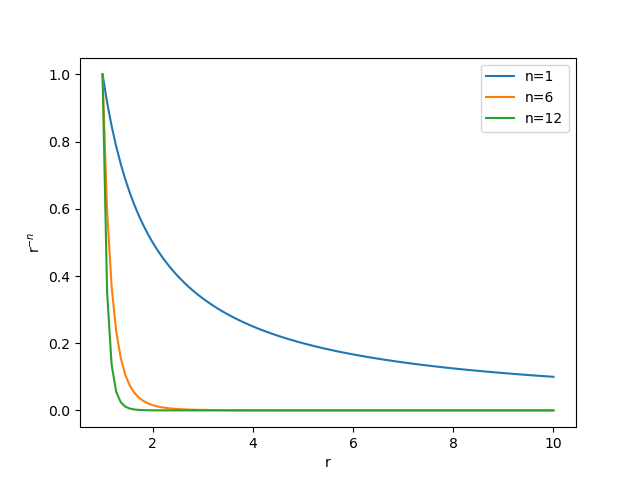

In [6]:
import numpy as np
import matplotlib.pyplot as plt

distances = np.linspace(1, 10, 100)

plt.figure()
plt.plot(distances, 1/distances, label="n=1")
plt.plot(distances, 1/distances**6, label="n=6")
plt.plot(distances, 1/distances**12, label="n=12")

plt.xlabel("r")
plt.ylabel("r$^{-n}$")
plt.legend()
plt.show()

Simply setting the van der Waals interactions to zero beyond a cutoff distance has undesirable consequences because the energy and its derivatives become discontinuous. This causes problems in optimization and simulations. To address this issue, a switching function is usually used to smoothly turn off the interaction between two cutoff values.

Using a cutoff distance by itself does not decrease the compuational cost significantly because calculating the $N^2$ distances is still required. To overcome this, a *neighbor list* is built to determine which atom pairs are closer than the cutoff distance and possibly a small buffer distance. Then, the *neighbor list* is only updated if an atom moves more than the buffer distance or at a fixed number of optimization or simulation steps.

Using a cutoff scheme is not appropriate for reducing the compuational cost of the electrostatic term. Instead, other approaches are used. For periodic systems, the Ewald summation technique decomposes the electrostatic energy to a short-range term that is computed in the real space and a long-range term that is computed in the reciprocal space. Then, the electrostatic energy can be computed to an arbitrary level of accuracy. The particle mesh Ewald (PME) sum technique reduces the computational scaling to $N {\rm log} N$. For aperiodic systems, the fast multipole method (FMM) method leverages the significant cancellation in charge-charge interactions between separated regions in space. It can then express the interaction in terms of highly truncated multipoles. FMM is a linear scaling algorithm.

It should be noted that the scaling behavior represents the *relative* time one system requires compared another system of different size. It does not determine the *absolute* time required for the computation. Thus, even though the FMM approach has better scaling than the PME approach, it is only faster for very large systems. The initial overhead for performing the FMM scheme can be quite large.

## Examples
### Implementing the TIP3P Water Model
To illustrate how force field methods are implemented, we will show how we can calculate the energy of water using the TIP3P water model. For the bonded TIP3P terms, we have only one bond stretching term and one angle bending term, each requiring two parameters. We also have two van der Waals terms for the hydrogen and the oxygen atoms, each requiring two parameters. We also need to specify the partial charges for oxygen and hydrogen. The following table lists all the required parameters:

|Parameter              | Value                      |
|-----------------------|----------------------------|
|$k_{\rm OH}$           |462750.4 kJ/mol⋅nm$^2$      |
|$r_{\rm OH, eq}$       |0.09572 nm                  |
|$k_{\rm HOH}$          |836.8 kJ/mol⋅rad$^2$        |
|$\theta_{\rm HOH, eq}$ |1.82421813418 rad           |
|$q_{\rm O}$            |-0.834e                     |
|$q_{\rm H}$            |0.417e                      |
|$\sigma_{\rm O}$       |0.31507524065751241 nm      |
|$\sigma_{\rm H}$       |1 nm                        |
|$\epsilon_{\rm O}$     |0.635968 kJ/mol             |
|$\epsilon_{\rm H}$     |0 kJ/mol                    |

We have a box of water. We will calculate the force field energy using our own implementation and compare the energy to that obtained by the OpenMM package. We will utilize functions from the Open Babel package for reading and processing the geometry.

In [7]:
# Let's first visualize the water box
import nglview as nv
from openbabel import openbabel as ob

conv = ob.OBConversion()
mol = ob.OBMol()
conv.ReadFile(mol, "water.pdb")
print("The number of atoms is", mol.NumAtoms())
print("The number of residues is", mol.NumResidues())

view = nv.show_openbabel(mol)
view.add_representation("licorice")
view.center()
view

The number of atoms is 300
The number of residues is 100


NGLWidget()

In [8]:
# Now we will define functions that calculate the force field energy terms
import math

def bond_energy(mol):
    energy = 0.0
    r_eq = 0.09572
    k = 462750.4
    
    # We will loop over all the bonds in all the molecules and calculate the energy
    for bond in ob.OBMolBondIter(mol):
        r = bond.GetLength()/10.0 # Convert to nm
        energy += 1.0/2.0 * k * (r-r_eq)**2
            
    return energy

def angle_energy(mol):
    energy = 0.0
    theta_eq = 1.82421813418
    k = 836.8
    
    # We will loop over all the angles in all the molecules and calculate the energy
    for angle in ob.OBMolAngleIter(mol):
        # Notice the indexing
        a1 = mol.GetAtom(angle[1] + 1)
        a2 = mol.GetAtom(angle[0] + 1)
        a3 = mol.GetAtom(angle[2] + 1)

        theta = mol.GetAngle(a1, a2, a3) * math.pi/180.0 # Convert to radian
        energy += 1.0/2.0 * k * (theta-theta_eq)**2
            
    return energy

def nonbonded_energy(mol):
    # This function calculates the nonbonded energy. Notice that the nonbonded energy
    # between atoms in the same water molecule is zero because their interaction is accounted for
    # using the bonded terms. We will loop over all atom pairs in different molecules.
    
    fragments = mol.Separate() # Separate the molecule to all independent fragments
    electrostatic_energy = 0.0
    vdw_energy = 0.0
    
    # Define a dictionary of the partial charges
    charges = {8: -0.834, 1: 0.417}
    sigmas = {8: 0.31507524065751241, 1: 1}
    epsilons = {8: 0.635968, 1: 0}
    
    # We loop only over the unique pairs of molecules
    for i in range(len(fragments)):
        mol1 = fragments[i]
        for j in range(i+1, len(fragments)):
            mol2 = fragments[j]
            
            for a1 in ob.OBMolAtomIter(mol1):
                for a2 in ob.OBMolAtomIter(mol2):
                    r = a1.GetDistance(a2) / 10.0 # Convert to nm
                    at1 = a1.GetAtomicNum()
                    at2 = a2.GetAtomicNum()
                    
                    # Calculate electrostatic energy
                    epsilon_0 = 8.854187812813e-12
                    e = 1.602176634e-19
                    Na = 6.02214076e23
                    conversion_factor = 1.0/(4.0*math.pi*epsilon_0)*e**2*Na * 1e9/1000.0 # To kJ/mol
                    q1 = charges[at1]
                    q2 = charges[at2]
                    electrostatic_energy += q1*q2/r * conversion_factor
                    
                    # Calculate van der Waals energy
                    # Get the values of sigma and epsilon for the atoms
                    s1 = sigmas[at1]
                    s2 = sigmas[at2]
                    e1 = epsilons[at1]
                    e2 = epsilons[at2]
                    
                    # Now obtain sigma and epsilon for the atom pairs using the combination rule
                    sigma = (s1 + s2)/2.0
                    epsilon = math.sqrt(e1*e2)
                    
                    vdw_energy += 4.0*epsilon*( (sigma/r)**12 - (sigma/r)**6 )

    energy = electrostatic_energy + vdw_energy
    
    return energy

E_bond = bond_energy(mol)
E_angle = angle_energy(mol)
E_nonbonded = nonbonded_energy(mol)
ff_energy = E_bond + E_angle + E_nonbonded

print("The calculated force field energy is", ff_energy, "kJ/mol")

The calculated force field energy is -4330.532253374339 kJ/mol


In [9]:
# Now we will calculate the energy using the OpenMM package
import openmm.app as app
import openmm as mm
import openmm.unit as unit

pdb = app.PDBFile('water.pdb')
forcefield = app.ForceField('tip3p.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, rigidWater=False)

# We need to define an integrator and a simulation object even though we are only calculating a single point energy
integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds)
simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
print("The calculated force field energy using OpenMM is", energy.value_in_unit(unit.kilojoule/unit.mole), "kJ/mol")
print("The difference is", energy.value_in_unit(unit.kilojoule/unit.mole) - ff_energy, "kJ/mol")

The calculated force field energy using OpenMM is -4330.531883984761 kJ/mol
The difference is 0.0003693895778269507 kJ/mol


### Calculating Conformational Energies
We will illustrate now the calculation of the relative conformational energy of 1,2-dichloroethane. We will perform rigid dihedral scans using several force fields implemented in the Open Babel package and compare their profiles.

In [10]:
# Let's first visualize the water box
import nglview as nv
from openbabel import openbabel as ob
import numpy as np

conv = ob.OBConversion()
mol = ob.OBMol()
conv.ReadFile(mol, "dichloro_ethane.xyz")

view = nv.show_openbabel(mol)
view

NGLWidget()

In [11]:
energies = {}
forcefields = ["UFF", "MMFF94", "GAFF", "GHEMICAL"]
angles = range(0, 361, 10) # Scan the energy in 10 degrees steps
dihedral_atoms = [3, 2, 1, 6] # Cl-C-C-Cl torsion
atoms = [mol.GetAtom(atom) for atom in dihedral_atoms]

for ff in forcefields:
    forcefield = ob.OBForceField_FindForceField(ff)
    energies[ff] = []
    
    for angle in angles:
        # Change the angle and calculate the energy
        mol.SetTorsion(atoms[0], atoms[1], atoms[2], atoms[3], angle*np.pi/180.0)
        forcefield.Setup(mol)
        energies[ff].append(forcefield.Energy())
    
    # Obtain the relative energy
    energies[ff] = np.array(energies[ff])
    energies[ff] -= np.min(energies[ff])
    if ff == "MMFF94":
        energies[ff] *= 4.148 # Convert to kJ/mol

<IPython.core.display.Javascript object>


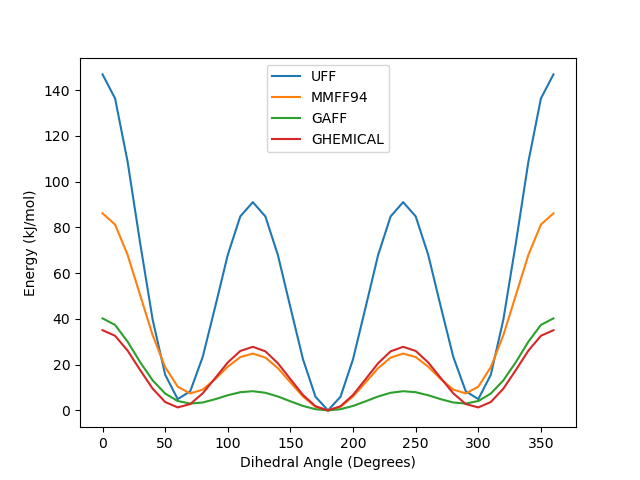

In [12]:
# Now plot the energies
import matplotlib.pyplot as plt

plt.figure()
for ff in forcefields:
    plt.plot(angles, energies[ff], label=ff)

plt.xlabel("Dihedral Angle (Degrees)")
plt.ylabel("Energy (kJ/mol)")
plt.legend()
plt.show()

The force fields generate the expected energy profile where the *trans* and *gauche* conformations are minima and the *cis* configuration is a maximum. However, the relative energies between the conformers are widely different for the different force fields.

It should be emphasized that the Open Babel package may not follow the correct perscription for defining the force field parameters. For example, the partial charges for the GAFF force field should be calculated using the RESP procedure but in Open Babel Gasteiger Charges are used.

# Quantum Mechanics/Molecular Mechanics (QM/MM) Methods
Force field methods are inherently less accurate than quantum mechanical methods. Furthermore, standard force fields cannot handle bond-breaking and bond-forming. The lack of parameters is also a common problem for force field methods, especially for metallic systems. However, sometimes the system of interest is too large to be studied by quantum mechanical methods. In such a situation, we can imagine using a hybrid approach where the important part of the system is treated quantum mechanically while the less important part is treated classically. This is the essense of QM/MM methods.

In QM/MM methods, the Hamiltonian and the energy are divided into three terms:
\begin{align}
    \textbf{H}_{\rm total} &= \textbf{H}_{\rm QM} + \textbf{H}_{\rm MM} + \textbf{H}_{\rm QM/MM} \\
    E_{\rm total} &= E_{\rm QM} + E_{\rm MM} + E_{\rm QM/MM}
\end{align}
The first two terms describe the QM and MM regions, respectively, and are handled using the same approaches discussed before. The third term describes the interaction between the QM and the MM regions.

## The Interaction between the QM and MM Regions
The difficulty in QM/MM methods is in defining the $\textbf{H}_{\rm QM/MM}$ term, or how the QM and MM regions interact. There are three different levels of sophistication:
- Mechanical embedding.
- Electrostatic embedding.
- Polarizable embedding.

### Mechanical Embedding
In mechanical embedding, the QM and MM regions interact only through bonded and steric effect, and possibly through classical charge-charge interactions. The QM atoms are assigned van der Waals parameters and partial charges and the interaction is treated classically. Furthermore, if there are bonds between the QM and MM regions, then these bonds are described classically using the bonded force field terms. The mechanical embedding scheme is poor because the MM atoms do not polarize the QM region.

### Electrostatic Embedding
In electrostatic embedding, the MM atoms polarize the QM region and therefore affect the QM wavefunction. If the MM atoms are represented by partial charges, the partial charged are treated analogously to nuclear charges and therefore affect the one-electron Hamiltonian. Additionally, the bonded terms are also used in there are bonds between the QM and MM regions.

### Polarizable Embedding
In polarizable embedding, the QM atoms also polarize the MM region. This is obviously possible only if a polarizable force field is used for the MM region. An iterative procedure is required in order to determine the electric fields in the QM and MM regions self-consistently. Polarizable embedding is significantly more computationally expensive than the previous two methods.

## Covalent Bonds between the QM and MM Regions
The easiest situation is when there are no covalent bonds between the QM and MM regions, for example when the MM region is only used to represent solvent molecules. However, if there are bonds between the QM and MM regions, then cutting these bonds in the QM calculation will leave one or more unpaired electrons. "Link" atoms, usually hydrogens, are typically used to terminate these dangling bonds.

Another issue is the handling of the bonded terms. A decision has to be made on which of the bend and torsional terms need to be included in the interaction term. For example, bending terms that involve two MM atoms and one QM atom are usually included, but bending terms that involve one MM atom and two QM atoms are often neglected.

## The ONIOM Method
The ONIOM (Our own N-layered Integrated molecular Orbital Molecular mechanics) method is a general approach for mixing different theoretical methods (usually two or three) with different accuracies. For two-method calculations, we treat a small model system using both the high-level and the low-level methods. We also treat the whole system using the low-level method. Then, we estimate the energy using the following formula:
\begin{align}
    E_{\rm ONIOM}(\textrm{real system, high level}) = E_\textrm{high level}(\textrm{model system}) -
                                                   E_\textrm{low level}(\textrm{model system}) + 
                                                   E_\textrm{low level}(\textrm{real system}).
\end{align}
Analogous expression can be used for multi-level calculations but more intermediate terms are needed.

## Challenges for QM/MM Methods
One of the challenges is that the QM wavefunction is not localized to the QM region but extends beyond the boundary to the MM region. This can lead to significant distortion of the wavefunction, especially if diffuse functions are used in the presence of positive MM charges. In the QM treatment, this is mitigated by the exchange-repulsion term which limits the accumulation of the electron density.

Another major problem in QM/MM methods is the ambiguity in the proper assignment of the QM and MM regions. Ideally, the QM region should be large enough to ensure the convergence of the property of interest. This, however, may require a large QM region that is computationally expensive.

The application of QM/MM method for dynamical problems is also challenging. For example, during geometry optimization or molecular dynamics simulation, some atoms may move from one region to another. A smooth switching from the QM to the MM description or from the MM to the QM description must be used in order to ensure that the energy is continuous.

Lastly, one challeging issue in QM/MM methods is the sampling of the configuration. The energy of the QM/MM system may be sensitive to the specific arrangement of the MM atoms. For example, for computing the energy profile of an enzymatic chemical reaction, the position of the QM atoms can be optimized in the presence of fully relaxed MM atoms. However, if significant structural changes in the MM region happen at any point during the computation of the energy profile, the energy may be discontinuous. The MM atom configuration can be frozen, but then the energy may be sensitive to the particular configuration chosen. Unfortunately, sufficient sampling of the configuration space can be prohibitively expensive because of the high computational cost of QM methods.

## Useful Resources

- Cramer, C. J. *Essentials of Computational Chemistry: Theories and Models*, 2nd ed.; John Wiley & Sons: Chichester, England, 2004. (Chapters 2 and 13)
- Jensen, F. *Introduction to Computational Chemistry*, 3rd ed.; John Wiley & Sons: Nashville, TN, 2017. (Chapter 2)